In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import seaborn as sns

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### Import data

In [2]:
df = pd.read_excel('DatasetEN.xlsx',index_col=0) #load data
print(df.shape)
df

(49028, 22)


,Status,Target date,Closed,Category,Subcategory,Call Type,Department,Call Date,Number of days current,Department.1,...,Time spent for Second Line,Date/time of creation,Date/time of change,Closure Date,Completion Date,Duration,Actual duration,Escalated,Major call,Entry
Line,,,,,,,,,,,,,,,,,,,,,
Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,True,ICT SAP,SD (Verkoop),ICT Verstoring,NaN,2013-11-22 08:54:00,288,Klantenservice - Klantenservice-A - K&O,...,00:00:00,2013-11-22 08:54:34,2015-01-15 13:14:12,2015-01-15 13:14:00,2015-01-15 13:14:00,2 uur,1900-05-22 09:20:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-09-18 11:52:00,True,ICT GIS,Smallworld NRM,ICT Verstoring,NaN,2014-06-04 11:52:00,322,Aanleg Leidingen - Aansluitleidingen - K&O,...,00:00:00,2014-06-04 11:52:15,2015-09-10 12:52:18,2015-09-10 12:52:00,2015-09-10 12:52:00,5 dagen,1900-06-08 09:30:00,True,NaN,E-mail
Second line call,Afgehandeld,2016-12-30 18:00:00,True,ICT GIS,Arcgis,ICT Verstoring,NaN,2014-07-21 15:15:00,183,NaN,...,00:00:00,2014-07-21 15:21:58,2015-04-08 07:57:11,2015-04-08 07:57:00,2015-04-08 07:57:00,5 dagen,1900-03-31 01:12:00,True,NaN,Telefonisch
Second line call,Afgehandeld,2015-07-17 15:45:00,True,ICT Infra,Netwerkverbinding,ICT Verstoring,NaN,2014-10-09 15:45:00,169,Productie - Centraal - K&O,...,00:00:00,2014-10-09 15:45:51,2015-06-16 14:28:58,2015-06-16 14:28:00,2015-06-16 14:28:00,5 dagen,1900-03-24 07:13:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-02-27 10:42:00,True,ICT Overige applicaties,Kijk op water,ICT Vraag,NaN,2014-10-20 10:42:00,75,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,...,00:00:00,2014-10-20 10:42:31,2015-02-05 09:10:00,2015-02-05 09:09:00,2015-02-05 09:09:00,5 dagen,1900-02-06 06:57:00,True,NaN,E-mail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
First line call,Omgezet naar wijziging,2021-03-15 07:58:00,True,ICT GIS,Smallworld NRM,ICT Service Request,K&O - Aanleg leidingen - HAL,2021-03-12 15:58:00,0,Aanleg leidingen - K&O,...,00:00:00,2021-03-12 15:58:11,2021-03-12 16:24:37,2021-03-12 16:24:00,2021-03-12 16:24:00,4 uur,00:26:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 10:32:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 10:32:51,2021-03-13 14:13:56,2021-03-13 14:13:00,2021-03-13 14:13:00,4 uur,00:00:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 12:22:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 12:22:56,2021-03-13 14:14:02,2021-03-13 14:14:00,2021-03-13 14:14:00,4 uur,00:00:00,False,NaN,E-mail


In [3]:
df.keys()

Index(['Status', 'Target date', 'Closed', 'Category', 'Subcategory',
       'Call Type', 'Department', 'Call Date', 'Number of days current',
       'Department.1', 'Operator Group', 'Time spent for First line',
       'Time spent for Second Line', 'Date/time of creation',
       'Date/time of change', 'Closure Date', 'Completion Date', 'Duration',
       'Actual duration', 'Escalated', 'Major call', 'Entry'],
      dtype='object')

In [4]:
df.shape

(49028, 22)

## EDA

### Filter important columns

In [5]:
df = df[['Status', 'Target date','Category','Subcategory','Call Type','Department.1','Operator Group','Date/time of creation','Closure Date','Duration','Entry']]
df = df.reset_index()

In [6]:
oldsize = df.shape
oldsize

(49028, 12)

Create a column that represents the total duration of a call:

In [7]:
df['actual duration'] = df['Closure Date'] - df['Date/time of creation']

In [8]:
df.head()

,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry,actual duration
0,Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,ICT SAP,SD (Verkoop),ICT Verstoring,Klantenservice - Klantenservice-A - K&O,ICT ServiceDesk,2013-11-22 08:54:34,2015-01-15 13:14:00,2 uur,E-mail,419 days 04:19:26
1,Second line call,Afgehandeld,2015-09-18 11:52:00,ICT GIS,Smallworld NRM,ICT Verstoring,Aanleg Leidingen - Aansluitleidingen - K&O,ICT ServiceDesk,2014-06-04 11:52:15,2015-09-10 12:52:00,5 dagen,E-mail,463 days 00:59:45
2,Second line call,Afgehandeld,2016-12-30 18:00:00,ICT GIS,Arcgis,ICT Verstoring,NaN,ICT Technisch beheer,2014-07-21 15:21:58,2015-04-08 07:57:00,5 dagen,Telefonisch,260 days 16:35:02
3,Second line call,Afgehandeld,2015-07-17 15:45:00,ICT Infra,Netwerkverbinding,ICT Verstoring,Productie - Centraal - K&O,ICT Technisch beheer,2014-10-09 15:45:51,2015-06-16 14:28:00,5 dagen,E-mail,249 days 22:42:09
4,Second line call,Afgehandeld,2015-02-27 10:42:00,ICT Overige applicaties,Kijk op water,ICT Vraag,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-10-20 10:42:31,2015-02-05 09:09:00,5 dagen,E-mail,107 days 22:26:29


In [9]:
df.keys()

Index(['Line', 'Status', 'Target date', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group', 'Date/time of creation',
       'Closure Date', 'Duration', 'Entry', 'actual duration'],
      dtype='object')

### Remove categorical entries that are not sufficiently represented in the dataset:

In [11]:
df.dtypes

Line                              object
Status                            object
Target date               datetime64[ns]
Category                          object
Subcategory                       object
Call Type                         object
Department.1                      object
Operator Group                    object
Date/time of creation     datetime64[ns]
Closure Date              datetime64[ns]
Duration                          object
Entry                             object
actual duration          timedelta64[ns]
dtype: object

Describe the categorical variables

In [12]:
df[['Status', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group','Duration', 'Entry','Line']].describe()

,Status,Category,Subcategory,Call Type,Department.1,Operator Group,Duration,Entry,Line
count,49028,49028,49028,49028,41778,49028,49028,49028,49028
unique,5,29,200,24,76,10,9,9,2
top,Afgehandeld,ICT Infra,-,ICT Vraag,ICT - ICT Services & Infra - BO,ICT ServiceDesk,2 uur,E-mail,First line call
freq,30171,11714,10551,18581,2977,44450,34191,27559,38507


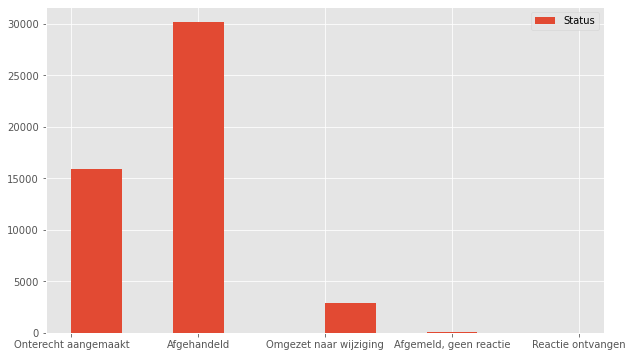

In [13]:
status_type = df['Status']
status_type.hist(legend = bool)

Only include the first 3 categories because the other 2 are not properly represented

In [14]:
df = df[df["Status"].str.contains("Afgehandeld", case = False) | df["Status"].str.contains("Onterecht aangemaakt", case = False)| df["Status"].str.contains("Omgezet naar wijziging", case = False)]

Perform similar cleaning on other categorical features

In [15]:
#remove call with a category type that is not properly represented
category_type = df['Category']
category_type.value_counts()
g = df.groupby('Category')
df = g.filter(lambda x: len(x) > 10)

#do the same for subcategory
category_type = df['Subcategory']
category_type.value_counts()
g = df.groupby('Subcategory')
df = g.filter(lambda x: len(x) > 10)

#remove call type instances
call_type = df['Call Type']
call_type.value_counts()
g = df.groupby('Call Type')
df = g.filter(lambda x: len(x) > 10)


#remove department type instances
department_type = df['Department.1']
department_type.value_counts()
g = df.groupby('Department.1')
df = g.filter(lambda x: len(x) > 10)

#remove poor represented operator groups
operator_type = df['Operator Group']
operator_type.value_counts()
g = df.groupby('Operator Group')
df = g.filter(lambda x: len(x) > 10)

We decided to remove instances that contain a unique category that, in other words categories that contain less than 10 instances. In the company there have been several changes over the years and could explain why some of these category types are not used often/anymore and that is why we decided to remove them. 

#### We look specifically at the entry types because it relates to one of our research questions

In [16]:
entry_type = df['Entry']
entry_type.value_counts()

E-mail                22003
Telefonisch           14268
Persoonlijk            3220
SelfServiceDesk        1383
Topdesk Formulier       524
Skype                    23
Zelf geconstateerd       20
FO-mail                  16
PA-mail                   1
Name: Entry, dtype: int64

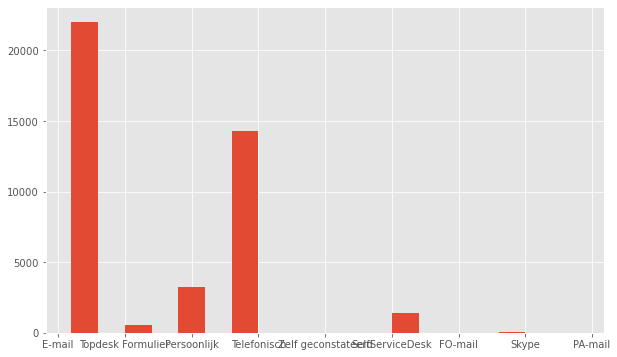

In [17]:
entry_type.hist(rwidth=0.5)

In [18]:
df = df[df["Entry"].str.contains("E-mail", case = False) | df["Entry"].str.contains("Telefonisch", case = False) | df["Entry"].str.contains("Persoonlijk", case = False)| df["Entry"].str.contains("SelfServiceDesk", case = False)]

In [33]:
print(oldsize)
print(df.shape)

(49028, 12)
(31022, 14)


We managed to filter out a lot of instances that are not sufficiently represented. Since we have a lot of data we decided to remove them from the dataset just for convenience. 

### Remove outliers in the numeric data:

Describe the numeric variables

In [20]:
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration
count,40874,40874,40874,40874
mean,2017-11-17 07:23:27.015396864,2017-11-13 06:58:07.295764736,2017-11-16 08:10:57.436668672,3 days 01:12:50.140896412
min,2014-12-23 16:24:00,2013-11-22 08:54:34,2015-01-05 08:34:00,-1 days +21:04:19
25%,2016-04-11 12:18:15,2016-04-07 16:31:36.500000,2016-04-11 08:32:45,0 days 00:00:20
50%,2017-09-12 18:51:30,2017-09-11 11:00:52.500000,2017-09-12 14:50:30,0 days 00:17:24
75%,2019-06-18 16:48:00,2019-06-12 10:16:14.749999872,2019-06-19 07:40:45,0 days 02:14:46.500000
max,2024-07-31 18:00:00,2021-03-13 13:33:57,2021-03-13 14:14:00,1653 days 02:58:58
std,NaN,NaN,NaN,24 days 18:49:24.242713964


Create a column that represent the duration as a numeric value instead of a date time value for easier analysis:

In [35]:
df['actual duration seconds'] = df['actual duration'].apply(lambda x : x.total_seconds())
df['actual duration minutes'] = df['actual duration'].apply(lambda x : x.total_seconds()/60)

In [36]:
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration','actual duration seconds','actual duration minutes']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration,actual duration seconds,actual duration minutes
count,31022,31022,31022,31022,3.102200e+04,31022.000000
mean,2017-12-01 10:49:09.176973312,2017-11-28 06:20:39.766819584,2017-11-29 23:35:59.320224768,1 days 17:15:19.553413706,1.485196e+05,2475.325890
min,2014-12-23 16:24:00,2014-12-04 08:05:36,2015-01-05 08:53:00,0 days 00:00:01,1.000000e+00,0.016667
25%,2016-05-03 12:48:45,2016-05-01 22:08:41.500000,2016-05-02 15:14:15,0 days 00:09:30,5.700000e+02,9.500000
50%,2017-10-05 16:17:00,2017-10-04 09:45:01.500000,2017-10-04 13:56:30,0 days 00:38:13,2.293000e+03,38.216667
75%,2019-06-26 11:16:00,2019-06-24 16:28:54.749999872,2019-06-26 08:44:30,0 days 12:44:04.750000,4.584475e+04,764.079167
max,2021-05-14 19:00:00,2021-03-13 13:33:57,2021-03-13 14:14:00,49 days 22:25:37,4.314337e+06,71905.616667
std,NaN,NaN,NaN,5 days 05:12:08.900292381,4.507289e+05,7512.148338


Plot the distribution of the duration:

Remove the outliers in duration

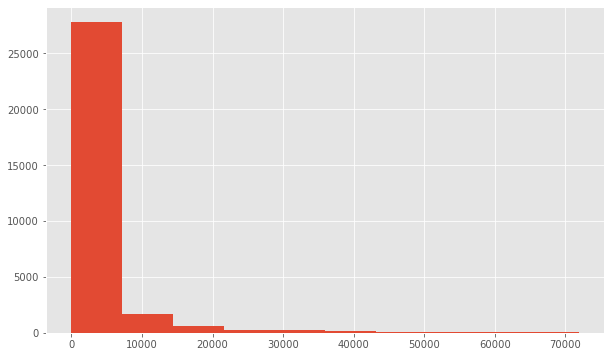

In [42]:
df['actual duration'].astype('timedelta64[m]').hist()

In [43]:
df = df[df['actual duration']>pd.Timedelta(0,'s')]
df = df[df['actual duration']< pd.Timedelta(50,'d')]

df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration
count,31022,31022,31022,31022
mean,2017-12-01 10:49:09.176973312,2017-11-28 06:20:39.766819584,2017-11-29 23:35:59.320224768,1 days 17:15:19.553413706
min,2014-12-23 16:24:00,2014-12-04 08:05:36,2015-01-05 08:53:00,0 days 00:00:01
25%,2016-05-03 12:48:45,2016-05-01 22:08:41.500000,2016-05-02 15:14:15,0 days 00:09:30
50%,2017-10-05 16:17:00,2017-10-04 09:45:01.500000,2017-10-04 13:56:30,0 days 00:38:13
75%,2019-06-26 11:16:00,2019-06-24 16:28:54.749999872,2019-06-26 08:44:30,0 days 12:44:04.750000
max,2021-05-14 19:00:00,2021-03-13 13:33:57,2021-03-13 14:14:00,49 days 22:25:37
std,NaN,NaN,NaN,5 days 05:12:08.900292381


#### Todo find out how to perform correlation matrix and scatter plots on datetime data

In [45]:
df.corr()

,actual duration seconds,actual duration minutes
actual duration seconds,1.0,1.0
actual duration minutes,1.0,1.0


In [26]:
df[['actual duration','Target date']].corr()

""


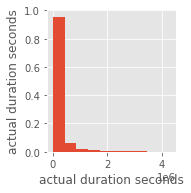

In [27]:
sns.pairplot(df)

### Q1: Does the workload vary depending on time of year/ time of the month / day of the week /hour of the day?

#### Time series analysis

Check if there is some change in duration of calls over time

In [30]:
after2014 = df[df["Date/time of creation"]>=np.datetime64('2015-01-01')]

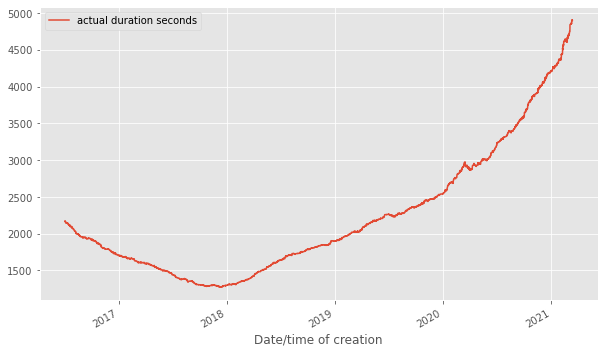

In [52]:
after2014[["Date/time of creation","actual duration seconds"]].set_index("Date/time of creation").rolling(24*365).median().plot()

#### There seems to be a increase in call durations over the years, but we are more interested in seasonality.
We averaged the times series over a window to get a general trend of the years. The increase in duration could be due to changes in company policy. To fully answer our research question we are going to look into the amount of incoming calls over different parts of the day.

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 365*24  # hourly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("Date/time of creation")['actual duration seconds'].interpolate("linear"),
    freq=decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

<ipython-input-88-b394b9c6ff6b>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(


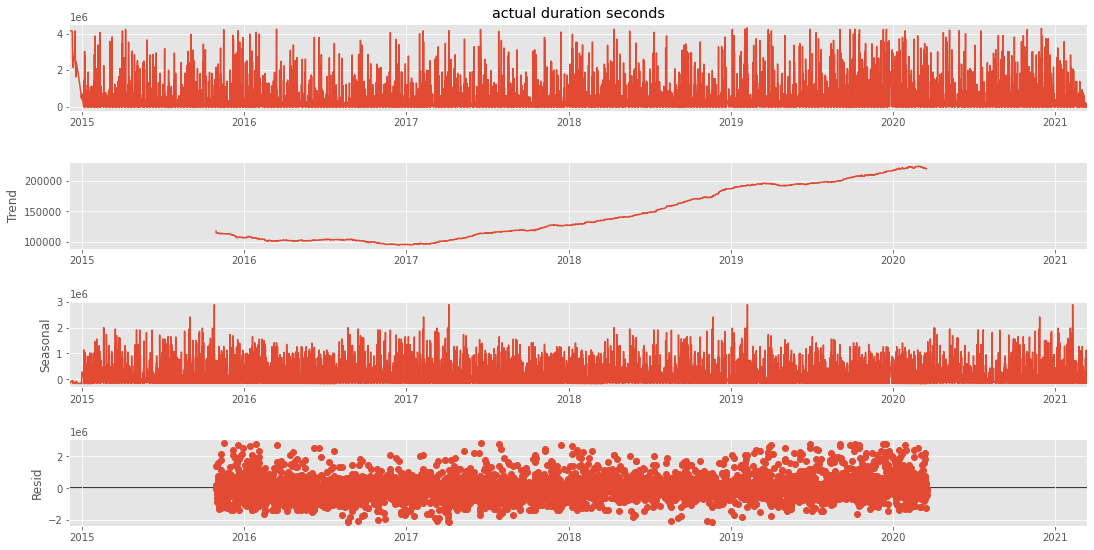

In [89]:
fig = decomposition.plot()
fig.set_size_inches(16, 8)


It is not possible to see any seasonality in this plot, hence a second plot will be created over a shorter period of time to see more details.

<ipython-input-93-f0bdb3942eb1>:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='bottom left')


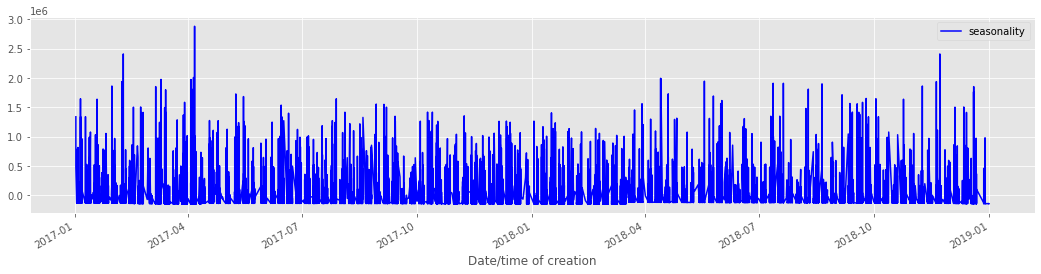

In [93]:
zoom_range = df[(df["Date/time of creation"]>=np.datetime64('2017-01-01')) & (df["Date/time of creation"]<np.datetime64('2019-01-01'))].index
indices = df.loc[zoom_range].set_index("Date/time of creation")
indices = indices.index
fig, ax = plt.subplots(figsize=(18,4))
seasonal[indices].plot(ax=ax, label="seasonality", color="blue")
plt.legend(loc='bottom left')

#### We now want to look into the duration of calls on specifc hours of day

In [185]:
df['creation hour of day'] = df['Date/time of creation'].dt.hour

decompfreq = 24  # hourly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("creation hour of day")['actual duration seconds'].interpolate("linear"),
    freq=decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

<ipython-input-185-2d55ed60d048>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(


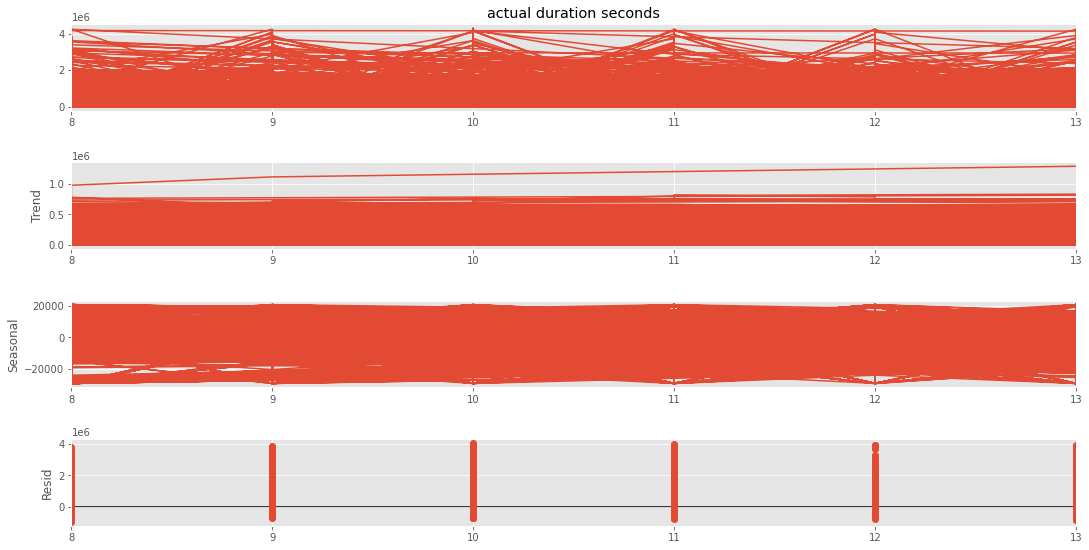

In [186]:
fig = decomposition.plot()
fig.set_size_inches(16, 8)

We cannot say anything about the duration of calls depended on what time they are incoming, so it's probably better to look at actual amount of incoming calls.

Text(0, 0.5, 'amount of incoming calls')

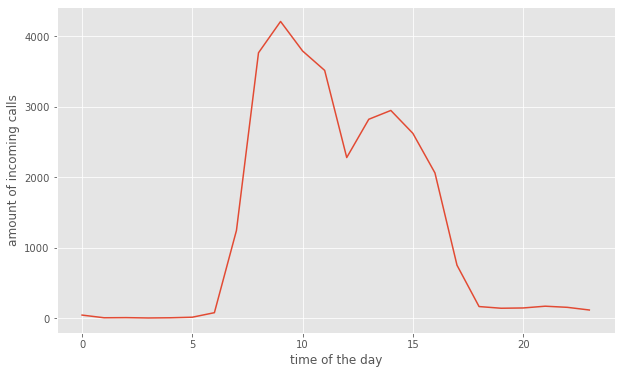

In [187]:
hoi = df.groupby('creation hour of day')
hoi = hoi.count()
plot = hoi['Line'].plot()
plot.set_xlabel('time of the day')
plot.set_ylabel('amount of incoming calls')

You can clearly see the working hours of the employees within the company, you can also see that after a certain time (probably lunch time) there is a decrease in the amount of incoming calls. It is probably more interesting to look into the entry types depending on the time of the day. Then you can schedule employees accordingly to receive and handle those calls.

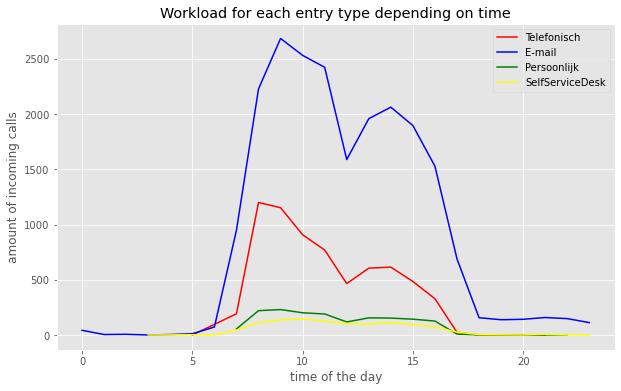

In [180]:
entrycount = df['Entry'].nunique()
entrytypes = df['Entry'].unique()
# plt.plot( hoi['Line'], color='blue')
color = ['red', 'blue', 'green', 'yellow']
for i in range(entrycount):
    subdf = df[df['Entry']==entrytypes[i]]
    
    subdf_count = subdf.groupby('creation hour of day')
    subdf_count = subdf_count.count()
    plt.plot(subdf_count['Line'], label = entrytypes[i], color=color[i])

plt.xlabel('time of the day')
plt.ylabel('amount of incoming calls')
plt.title('Workload for each entry type depending on time')
plt.legend()

#### Now I want to check if there is a difference in the duration of a call depending on the entry type

(6754, 14)
(21549, 14)
(1615, 14)
(1615, 14)
(1104, 14)


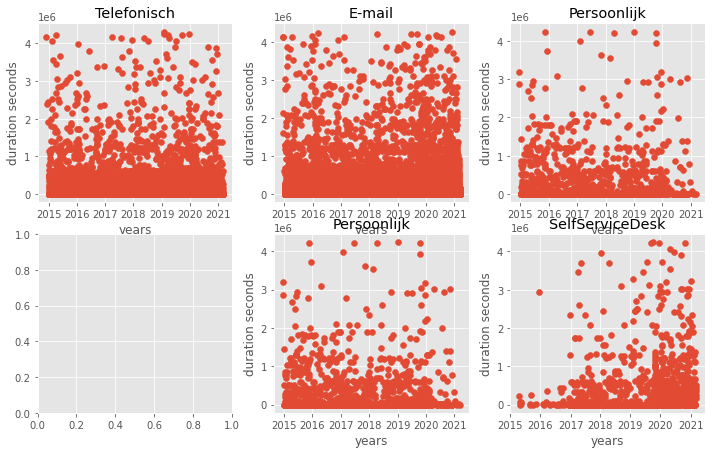

In [32]:
entrycount = df['Entry'].nunique()
entrytypes = df['Entry'].unique()
fig, subfigs = plt.subplots((int) (entrycount/2), (int) (entrycount - entrycount/2)+1)
fig.tight_layout()
for i in range(0,(int)(entrycount/2)):
    for j in range(i,(int) (entrycount- entrycount/2)+1):
        subdf = df[df['Entry']==entrytypes[i+j]]
        print(subdf.shape)
        subfigs[i,j].scatter(x=subdf['Date/time of creation'],y=subdf['actual duration seconds'],label=entrytypes[i+j])
        subfigs[i,j].title.set_text(entrytypes[i+j])
        subfigs[i,j].set_xlabel('years')
        subfigs[i,j].set_ylabel('duration seconds')